In [1]:
!pip install -q sacrebleu
!pip install -q rouge-score
!pip install -q bert-score
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoTokenizer, AutoModel
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import numpy as np
from tqdm import tqdm
import evaluate

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("adibvafa/BLIP-MIMIC-CXR")
model = BlipForConditionalGeneration.from_pretrained("adibvafa/BLIP-MIMIC-CXR").to(device)
model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [4]:
dataset = load_dataset("Fakhraddin/NLMCXR")
split_to_use = "validation"
data = dataset[split_to_use]
print(f"Loaded {len(data)} examples from {split_to_use} split.")

README.md:   0%|          | 0.00/642 [00:00<?, ?B/s]

data/train-00000-of-00003-627ed4d457a264(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00001-of-00003-b7ef6c3b205887(…):   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00003-738198d486559e(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/validation-00000-of-00001-d17faea78(…):   0%|          | 0.00/273M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5925 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1505 [00:00<?, ? examples/s]

Loaded 1505 examples from validation split.


In [5]:
# here i am defining batch size
BATCH_SIZE = 64

# function to handle batching
def collate_fn(batch):
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]
    inputs = processor(images=images, return_tensors="pt")
    return inputs, texts

# i am creating DataLoader
eval_dataloader = DataLoader(data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

preds, refs = [], []

print(f"Starting generation with batch size: {BATCH_SIZE}...")

# batched generation loop for the data
with torch.no_grad():
    for inputs, batch_texts in tqdm(eval_dataloader, desc="Generating batches"):
        inputs = inputs.to(device)
        output_ids = model.generate(**inputs, max_new_tokens=50)

        # decoding the whole batch at once
        batch_preds = processor.batch_decode(output_ids, skip_special_tokens=True)

        preds.extend(batch_preds)
        refs.extend(batch_texts)

print(f"Generated {len(preds)} captions.")

Starting generation with batch size: 64...


Generating batches: 100%|██████████| 24/24 [02:22<00:00,  5.95s/it]

Generated 1505 captions.


In [6]:
print("Computing Cosine Similarity...")

# loading bert-base-uncased for BERT score calculation
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

def get_embeddings_batched(text_list, batch_size=128):
    """
    Extracts CLS embeddings for a list of texts in batches to speed up processing.
    """
    all_embs = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i : i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embs = outputs.last_hidden_state[:, 0, :]
        all_embs.append(embs.cpu())
    return torch.cat(all_embs, dim=0)

# get embedding for all preds and refs
pred_embs = get_embeddings_batched(preds)
ref_embs = get_embeddings_batched(refs)

# calculate cosine similarity
cosine_sims = torch.nn.functional.cosine_similarity(pred_embs, ref_embs, dim=1)
avg_cosine = cosine_sims.mean().item()

print(f"Avg. Cosine Similarity: {avg_cosine:.4f}")

Computing Cosine Similarity...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Avg. Cosine Similarity: 0.7011


In [7]:
# --- BLEU ---
print("Computing BLEU...")
avg_bleu = corpus_bleu(preds, [refs]).score
print(f"Avg. BLEU: {avg_bleu:.4f}")

# --- ROUGE ---
print("Computing ROUGE...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1s, rouge2s, rougeLs = [], [], []

for r, p in zip(refs, preds):
    s = scorer.score(r, p)
    rouge1s.append(s['rouge1'].fmeasure)
    rouge2s.append(s['rouge2'].fmeasure)
    rougeLs.append(s['rougeL'].fmeasure)

avg_rouge1 = np.mean(rouge1s)
avg_rouge2 = np.mean(rouge2s)
avg_rougeL = np.mean(rougeLs)

# --- BERTScore (Batched) ---
print("Computing BERTScore...")
bertscore_metric = evaluate.load("bertscore")
results = bertscore_metric.compute(predictions=preds, references=refs, model_type="bert-base-uncased", batch_size=64, device=device)
avg_bertscore = np.mean(results["f1"])

print("\n===== Final Evaluation Metrics =====")
print(f"Avg. Cosine Similarity: {avg_cosine:.4f}")
print(f"Avg. BLEU:              {avg_bleu:.4f}")
print(f"Avg. ROUGE-1:           {avg_rouge1:.4f}")
print(f"Avg. ROUGE-2:           {avg_rouge2:.4f}")
print(f"Avg. ROUGE-L:           {avg_rougeL:.4f}")
print(f"Avg. BERTScore (F1):    {avg_bertscore:.4f}")

Computing BLEU...
Avg. BLEU: 0.0828
Computing ROUGE...
Computing BERTScore...



===== Final Evaluation Metrics =====
Avg. Cosine Similarity: 0.7011
Avg. BLEU:              0.0828
Avg. ROUGE-1:           0.0504
Avg. ROUGE-2:           0.0020
Avg. ROUGE-L:           0.0402
Avg. BERTScore (F1):    0.4208


In [ ]:
for i in range(5):
    print(f"Reference: {refs[i]}")
    print(f"Prediction: {preds[i]}\n")

Reference: 1. Increased opacity in the right upper lobe with XXXX associated atelectasis may represent focal consolidation or mass lesion with atelectasis. Recommend chest CT for further evaluation. 2. XXXX opacity overlying the left 5th rib may represent focal airspace disease. There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality.
Prediction: final report chest radiograph indication on hazelburn syndrome, hazelburn syndrome, and hazelburn syndrome, five years ago, now with four weeks of cough and green sputum production, including one hour of fever and brown sputum production, five

Reference: Status post left mastectomy. Heart size normal. Lungs are clear.
Prediction: final report ches

### Plotting boxplot

/tmp/ipython-input-3509919474.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)


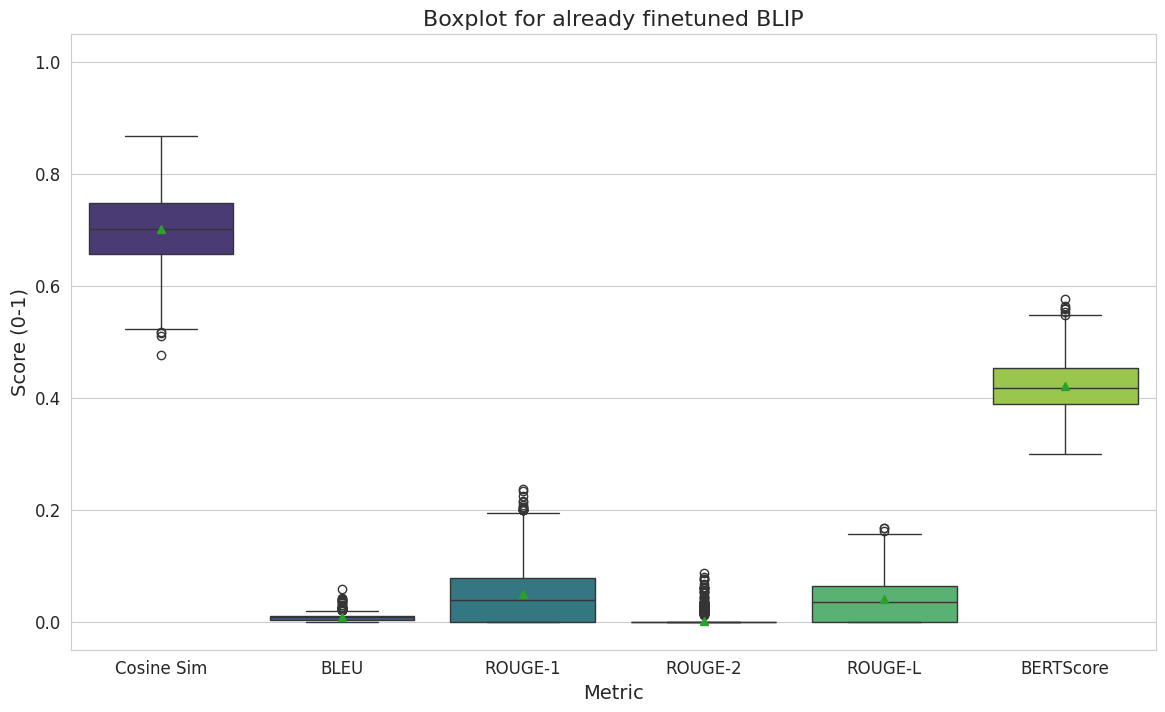


===== Statistical Summary =====
              mean     std     min     50%     max
Cosine Sim  0.7011  0.0641  0.4756  0.7021  0.8666
BLEU        0.0076  0.0058  0.0000  0.0080  0.0578
ROUGE-1     0.0504  0.0490  0.0000  0.0390  0.2376
ROUGE-2     0.0020  0.0088  0.0000  0.0000  0.0870
ROUGE-L     0.0402  0.0363  0.0000  0.0345  0.1681
BERTScore   0.4208  0.0461  0.3003  0.4174  0.5754


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sacrebleu import sentence_bleu

cosine_scores = cosine_sims.cpu().numpy()
bert_scores = results["f1"]

# Calculate Sentence-Level BLEU for distribution

bleu_scores = []
for p, r in zip(preds, refs):
    # normalizing the bleu values to 0 -1
    score = sentence_bleu(p, [r]).score
    bleu_scores.append(score / 100.0)

# Creating a DataFrame combining all metrics
df_metrics = pd.DataFrame({
    "Cosine Sim": cosine_scores,
    "BLEU": bleu_scores,
    "ROUGE-1": rouge1s,
    "ROUGE-2": rouge2s,
    "ROUGE-L": rougeLs,
    "BERTScore": bert_scores
})

# plotting
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Transforming data to long format for Seaborn
df_melted = df_metrics.melt(var_name="Metric", value_name="Score")
ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)
plt.title("Boxplot for already finetuned BLIP", fontsize=16)
plt.ylabel("Score (0-1)", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print("\n===== Statistical Summary =====")
print(df_metrics.describe().T[['mean', 'std', 'min', '50%', 'max']].round(4))